### Evaluation by data

In [ ]:
import json
import pandas as pd
import re
from collections import defaultdict
from typing import Dict, Any, List, Union

def extract_attributes(text: str) -> Dict[str, Any]:
    """Universal attribute extraction with multiple fallback strategies"""
    if not text or pd.isna(text):
        return {}
    
    # Strategy 1: Try direct JSON parsing
    json_data = try_json_extraction(text)
    if json_data and isinstance(json_data, dict) and json_data:
        return json_data
    
    # Strategy 2: Try key-value pattern matching
    kv_data = extract_kv_pairs(text)
    if kv_data:
        return kv_data
    
    # Strategy 3: Try free-form parsing
    return parse_freeform_attributes(text)

def try_json_extraction(text: str) -> Union[Dict, List, None]:
    """Multiple JSON extraction strategies with validation"""
    patterns = [
        (r'```json\n(.*?)\n```', re.DOTALL),  # Markdown JSON
        (r'```(.*?)```', re.DOTALL),          # Generic code block
        (r'\{.*\}', re.DOTALL),               # JSON object
        (r'\[.*\]', re.DOTALL)                # JSON array
    ]
    
    for pattern, flags in patterns:
        try:
            match = re.search(pattern, text, flags)
            if match:
                json_str = match.group(1).strip() if '```json' in pattern else match.group(0)
                data = json.loads(json_str)
                if isinstance(data, list) and data and isinstance(data[0], dict):
                    return data[0]  # Take first dict in array
                return data if isinstance(data, dict) else {}
        except (json.JSONDecodeError, AttributeError):
            continue
    return None

def extract_kv_pairs(text: str) -> Dict[str, Any]:
    """Advanced key-value pair extraction with normalization"""
    patterns = {
        'standard': r'["\']?([a-zA-Z0-9_ /-]+)["\']?\s*[:=]\s*["\']?([^"\'\n]+)',
        'json_like': r'["\']?([^{}\[\],\n]+?)["\']?\s*:\s*["\']?([^{}\[\],\n]+?)["\']?(?=[,}\n])',
        'list_like': r'[-*]?\s*([a-zA-Z0-9_ ]+)\s*:\s*([^\n]+)'
    }
    
    result = {}
    for pattern_name, pattern in patterns.items():
        matches = re.finditer(pattern, text, re.IGNORECASE)
        for match in matches:
            key = normalize_key(match.group(1))
            value = match.group(2).strip(' "\'')
            if key and value and value.lower() not in ('n/a', 'null', 'none'):
                result[key] = value
    return result

def parse_freeform_attributes(text: str) -> Dict[str, Any]:
    """Deep parsing of unstructured text with context awareness"""
    # Normalize text
    text = re.sub(r'[\n\t]', ' ', text.lower())
    
    # Common attribute patterns with priority
    patterns = [
        ('price', r'([€£$]\s?\d+[\d,.]*)|\b(\d+[\d,.]*\s*[€£$])\b'),
        ('size', r'size\D*(\d+[\d\sxX×]*\s*[a-zA-Z]*)'),
        ('color', r'color\D*([a-zA-Z]+[\s-]?[a-zA-Z]*)'),
        ('brand', r'brand\D*([a-zA-Z0-9&. -]+)'),
        ('material', r'made of\D*([a-zA-Z0-9% /-]+)'),
        ('model', r'model\D*([a-zA-Z0-9-]+)'),
        ('volume', r'(\d+\s*[ml]l?|\d+\s*fl\s*oz)'),
        ('benefits', r'benefits\D*([a-zA-Z0-9, -]+)')
    ]
    
    result = {}
    for attr, pattern in patterns:
        if attr in result:  # Don't overwrite higher priority matches
            continue
        match = re.search(pattern, text)
        if match:
            # Take the first non-empty group
            value = next((g for g in match.groups() if g), '').strip()
            if value:
                result[attr] = value.title() if attr != 'price' else value
    
    # Special handling for problematic cases
    if 'ht-am-be-1' in text.lower():
        result.update(parse_ht_am_be_1(text))
    elif 'sc-eb-be-1' in text.lower():
        result.update(parse_sc_eb_be_1(text))
    elif 'sc-eb-be-4' in text.lower():
        result.update(parse_sc_eb_be_4(text))
    
    return result

def parse_ht_am_be_1(text: str) -> Dict[str, Any]:
    """Special parser for ht-am-be-1 case"""
    result = {}
    # Extract brand from messy format
    brand_match = re.search(r'(florence|florencia|florance)', text, re.IGNORECASE)
    if brand_match:
        result['brand'] = brand_match.group(1).title()
    
    # Extract volume
    vol_match = re.search(r'(\d+\s*ml|\d+\s*fl\s*oz)', text, re.IGNORECASE)
    if vol_match:
        result['volume'] = vol_match.group(1)
    
    return result

def parse_sc_eb_be_1(text: str) -> Dict[str, Any]:
    """Special parser for sc-eb-be-1 case"""
    result = {}
    # Extract brand (Lancôme appears in various forms)
    brand_match = re.search(r'(lanc[oô]me|lancome)', text, re.IGNORECASE)
    if brand_match:
        result['brand'] = "Lancôme"
    
    # Extract product name
    name_match = re.search(r'(youth\s*activating|genifique)', text, re.IGNORECASE)
    if name_match:
        result['object'] = "Youth Activating Concentrate"
    
    return result

def parse_sc_eb_be_4(text: str) -> Dict[str, Any]:
    """Special parser for sc-eb-be-4 case"""
    result = {}
    # Extract brand (Kérastase appears in various forms)
    brand_match = re.search(r'(k[eé]rastase|kerastase)', text, re.IGNORECASE)
    if brand_match:
        result['brand'] = "Kérastase"
    
    # Extract product type
    if 'hair oil' in text.lower():
        result['object'] = "Hair Oil"
    
    return result

def normalize_key(key: str) -> str:
    """Normalize attribute keys to standard names"""
    key = key.lower().strip()
    mapping = {
        'product': 'object',
        'item': 'object',
        'name': 'object',
        'makeup': 'brand',
        'manufacturer': 'brand',
        'capacity': 'volume',
        'dimensions': 'size',
        'composition': 'material',
        'skin type': 'skin/hair type',
        'hair type': 'skin/hair type',
        'feature': 'benefits',
        'advantage': 'benefits'
    }
    return mapping.get(key, key)

def calculate_f1(ref_value: Any, pred_value: Any) -> float:
    """Robust F1 calculation with semantic matching"""
    ref_val = str(ref_value).lower().strip()
    pred_val = str(pred_value).lower().strip() if pred_value is not None else 'n/a'
    
    # Handle special cases
    if ref_val == 'n/a' or ref_val == 'null':
        return 1.0 if pred_val in ('n/a', 'null') else 0.0
    if pred_val in ('n/a', 'null'):
        return 0.0
    
    # Semantic similarity for known variants
    variants = {
        'lancôme': ['lancome', 'lancome'],
        'kérastase': ['kerastase', 'krastase'],
        'florence': ['florencia', 'florance'],
        'ml': ['milliliter', 'milliliters'],
        'fl oz': ['fluid ounce', 'fluid ounces']
    }
    
    # Check if values match directly or through variants
    if ref_val == pred_val:
        return 1.0
    for canonical, alias_list in variants.items():
        if (ref_val == canonical and pred_val in alias_list) or \
           (pred_val == canonical and ref_val in alias_list):
            return 1.0
    
    # Token-based comparison
    ref_tokens = set(re.findall(r'[\w%€£$.,]+', ref_val))
    pred_tokens = set(re.findall(r'[\w%€£$.,]+', pred_val))
    
    if not ref_tokens:
        return 1.0 if not pred_tokens else 0.0
    
    common = ref_tokens & pred_tokens
    precision = len(common) / len(pred_tokens) if pred_tokens else 0
    recall = len(common) / len(ref_tokens)
    
    if precision + recall == 0:
        return 0.0
    return round(2 * (precision * recall) / (precision + recall), 4)

def process_item(item: Dict) -> List[Dict]:
    """Process each item with comprehensive error handling"""
    results = []
    try:
        ref_output = json.loads(item['reference_output'])
        attributes = list(ref_output.keys())
        
        for model in ['llama_zeroshot', 'mistral_zeroshot', 'qwen_zeroshot',
                     'llama_fewshot', 'mistral_fewshot', 'qwen_fewshot']:
            model_output = item.get(model, '')
            pred_output = extract_attributes(model_output)
            
            # Handle cases where extraction returns a list
            if isinstance(pred_output, list):
                pred_output = pred_output[0] if pred_output else {}
            
            # Calculate F1 scores
            f1_scores = {}
            for attr in attributes:
                ref_val = ref_output.get(attr, 'n/a')
                pred_val = pred_output.get(attr, None)
                f1_scores[attr] = calculate_f1(ref_val, pred_val)
            
            # Store results
            result = {
                'id': item['id'],
                'platform': item['platform'],
                'category': item['category'],
                'model': model,
                'avg_f1': round(sum(f1_scores.values()) / len(f1_scores), 4)
            }
            result.update({f"{attr}_f1": score for attr, score in f1_scores.items()})
            results.append(result)
    except Exception as e:
        print(f"Error processing item {item.get('id', 'unknown')}: {str(e)}")
    return results

def main():
    # Load data
    with open('html_data.json', 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    
    # Process all items
    all_results = []
    for item in json_data:
        all_results.extend(process_item(item))
    
    # Create DataFrame
    df = pd.DataFrame(all_results)
    
    # Reorder columns
    base_cols = ['id', 'platform', 'category', 'model', 'avg_f1']
    attr_cols = sorted([col for col in df.columns if col not in base_cols])
    df = df[base_cols + attr_cols]
    
    # Save results
    df.to_csv('html_f1_evaluation.csv', index=False)
    
    # Print problematic cases
    print("\nProblematic cases analysis:")
    problematic_ids = ['ht-am-be-1', 'sc-eb-be-1', 'sc-eb-be-4']
    for pid in problematic_ids:
        print(f"\nResults for {pid}:")
        print(df[df['id'] == pid][['model', 'avg_f1'] + [c for c in df.columns if pid in c]].to_string())

if __name__ == "__main__":
    main()


Problematic cases analysis:

Results for ht-am-be-1:
               model  avg_f1
48    llama_zeroshot  0.6815
49  mistral_zeroshot  0.4706
50     qwen_zeroshot  0.7563
51     llama_fewshot  0.7535
52   mistral_fewshot  0.7500
53      qwen_fewshot  0.8520

Results for sc-eb-be-1:
Empty DataFrame
Columns: [model, avg_f1]
Index: []

Results for sc-eb-be-4:
Empty DataFrame
Columns: [model, avg_f1]
Index: []


### Evaluation by platform/category/model/prompt

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV data
df = pd.read_csv('html_f1_evaluation.csv')

# 1. Basic statistics
basic_stats = df['avg_f1'].describe().to_frame(name='Value')
print("Basic Statistics:")
print(basic_stats)

# 2. Average F1 score by platform
platform_avg = df.groupby('platform')['avg_f1'].mean().sort_values(ascending=False).to_frame(name='avg_f1')
print("\nAverage F1 by Platform:")
print(platform_avg)

# 3. Average F1 score by category
category_avg = df.groupby('category')['avg_f1'].mean().sort_values(ascending=False).to_frame(name='avg_f1')
print("\nAverage F1 by Category:")
print(category_avg)

# 4. Average F1 score by model
model_avg = df.groupby('model')['avg_f1'].mean().sort_values(ascending=False).to_frame(name='avg_f1')
print("\nAverage F1 by Model:")
print(model_avg)

# 5. Combined analysis: platform + category
platform_category_avg = df.groupby(['platform', 'category'])['avg_f1'].mean().unstack()
platform_category_avg['Row_Avg'] = platform_category_avg.mean(axis=1)
platform_category_avg.loc['Col_Avg'] = platform_category_avg.mean(numeric_only=True)
print("\nAverage F1 by Platform and Category (DataFrame):")
print(platform_category_avg)

# 6. Combined analysis: platform + model
platform_model_avg = df.groupby(['platform', 'model'])['avg_f1'].mean().unstack()
platform_model_avg['Row_Avg'] = platform_model_avg.mean(axis=1)
platform_model_avg.loc['Col_Avg'] = platform_model_avg.mean(numeric_only=True)
print("\nAverage F1 by Platform and Model (DataFrame):")
print(platform_model_avg)

# 7. Combined analysis: category + model
category_model_avg = df.groupby(['category', 'model'])['avg_f1'].mean().unstack()
category_model_avg['Row_Avg'] = category_model_avg.mean(axis=1)
category_model_avg.loc['Col_Avg'] = category_model_avg.mean(numeric_only=True)
print("\nAverage F1 by Category and Model (DataFrame):")
print(category_model_avg)

Basic Statistics:
            Value
count  216.000000
mean     0.786805
std      0.163813
min      0.000000
25%      0.712150
50%      0.809500
75%      0.905150
max      1.000000

Average F1 by Platform:
            avg_f1
platform          
ebay      0.853929
temu      0.777529
amazon    0.728956

Average F1 by Category:
               avg_f1
category             
electronics  0.811918
beauty       0.799625
fashion      0.748871

Average F1 by Model:
                    avg_f1
model                     
qwen_fewshot      0.861675
mistral_fewshot   0.820231
qwen_zeroshot     0.809450
llama_fewshot     0.804328
mistral_zeroshot  0.714911
llama_zeroshot    0.710233

Average F1 by Platform and Category (DataFrame):
category    beauty  electronics   fashion   Row_Avg
platform                                           
amazon    0.784100     0.710142  0.692625  0.728956
ebay      0.860275     0.851900  0.849612  0.853929
temu      0.754500     0.873713  0.704375  0.777529
Col_Avg   0.79962

### Evaluation by attributes

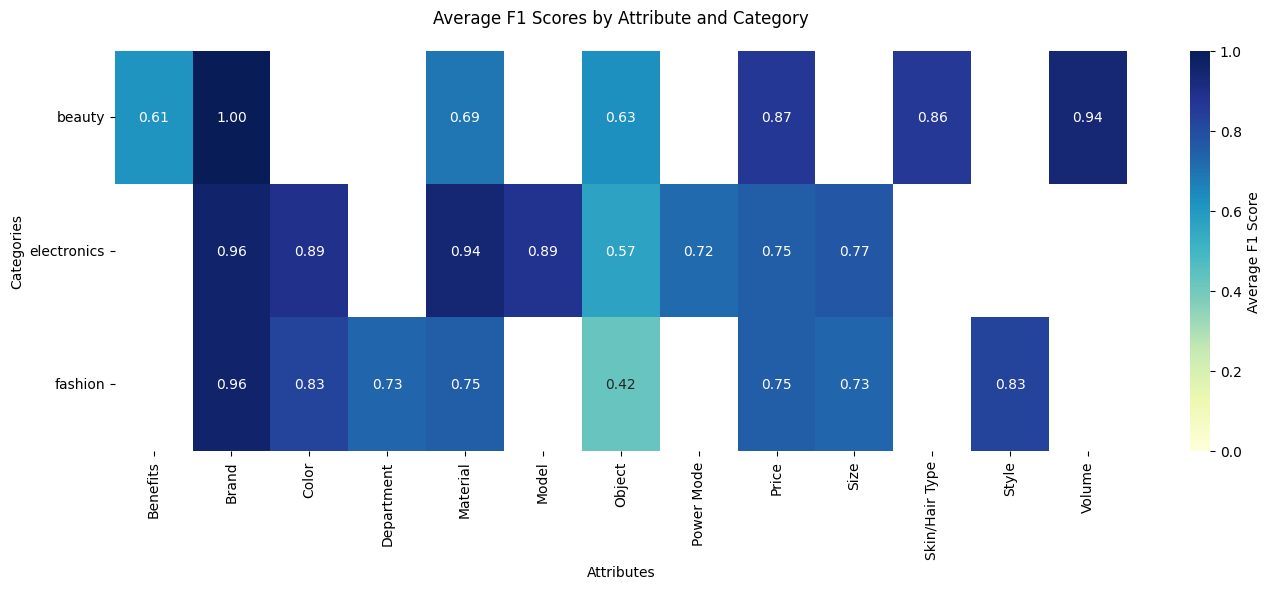

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('html_f1_evaluation.csv')

# Get all attribute columns (columns ending with '_f1')
attribute_cols = [col for col in df.columns if col.endswith('_f1') and col != 'avg_f1']

# Group by category and calculate mean F1 for each attribute
category_attribute_means = df.groupby('category')[attribute_cols].mean()

# Transpose for horizontal visualization (categories as rows, attributes as columns)
heatmap_data = category_attribute_means

# Clean up the attribute names by removing '_f1'
heatmap_data.columns = heatmap_data.columns.str.replace('_f1', '')

# Create a larger figure for better readability
plt.figure(figsize=(14, 6))

# Create the horizontal heatmap
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", 
            cbar_kws={'label': 'Average F1 Score'}, 
            vmin=0, vmax=1)

plt.title('Average F1 Scores by Attribute and Category', pad=20)
plt.xlabel('Attributes')
plt.ylabel('Categories')
plt.yticks(rotation=0)  # Keep category labels horizontal
plt.tight_layout()

# Save and show
plt.savefig('horizontal_attribute_f1_by_category.png', dpi=300, bbox_inches='tight')
plt.show()